# AX=YB
This notebook shows the process of calibrating the extrinsic parameters between the Vicon marker coordinate frame installed on an object with respect to the object CAD coordinate frame. We use the ICG 3D tracker algorithm to track the 3D pose of the object through its pointcloud observation and the ROS2 vicon bridge to get the pose of the markers installed on it.

## Instantiate the Interfaces
### ROS2

In [ ]:
from SimpleHandEye.interfaces.utils import addFoxyPath
addFoxyPath('/opt/ros/foxy')

In [ ]:
from SimpleHandEye.interfaces.ros2 import ROS2TFInterface
import rclpy
rclpy.init()    
tf_interface = ROS2TFInterface('world', 'base_link')

In [ ]:
tf_interface.getPose()

### ROS1

In [ ]:
from SimpleHandEye.interfaces.utils import addNoeticPath
addNoeticPath('/opt/ros/noetic')

In [ ]:
from SimpleHandEye.interfaces.ros import ROSTFInterface, initRosNode
initRosNode()
tf_interface = ROSTFInterface('vicon/world', 'vicon/wall/wall')

In [ ]:
tf_interface.getPose()

### April-Tag Tracker

In [ ]:
from SimpleHandEye.interfaces.cameras import RealSenseCamera
import cv2

def showImage(color_frame, depth_frame, ir1_frame, ir2_frame):
    cv2.imshow('image', color_frame)
    cv2.waitKey(33)

camera = RealSenseCamera(callback_fn=showImage)

intrinsics_params = camera.getIntrinsics()
K = intrinsics_params['RGB']['K']
D = intrinsics_params['RGB']['D']

In [ ]:
from SimpleHandEye.interfaces.apriltag import ApriltagTracker
tracker = ApriltagTracker(tag_size=0.172,
                          intrinsic_matrix=K,
                          distortion_coeffs=D)

tracker.getPose(camera.color_frame, tag_id=0)

In [ ]:
import time
from SimpleHandEye.interfaces.ros import ROSTFPublisher
tracker_tf_publisher = ROSTFPublisher('camera', 'tag0')

for _ in range(100):
    T = tracker.getPose(camera.color_frame, tag_id=0)
    if T is not None:
        tracker_tf_publisher.publish(T)
        time.sleep(0.3) 

## Instantiate the Solver

In [ ]:
from SimpleHandEye.solvers import OpenCVSolver
solver = OpenCVSolver()

## Collect The Calibration Dataset

In [ ]:
import ipywidgets as widgets
import numpy as np
from IPython.display import display
from pprint import pprint
from IPython.display import clear_output
np.set_printoptions(suppress=True, precision=3)

# The dataset
A_list = []
B_list = []
apriltag_info = []
apriltag_imgs_raw = []
apriltag_imgs_udist = []
def on_sample_clicked(b):
    A = tf_interface.getPose()
    img = camera.color_frame
    info = tracker.getPoseAndCorners(img, tag_id=0)
    B = info['pose']
    apriltag_info.append(info)
    apriltag_imgs_raw.append(img)
    apriltag_imgs_udist.append(tracker.undistortImage(img))
    print("A=")
    pprint(A)
    print("B=")
    pprint(B)
    # if A is not None and B is not None:
    A_list.append(A)
    B_list.append(B)
    print("*************")

def on_compute_clicked(b):
    try:
        X,Y = solver.solve(A_list, B_list)
        clear_output(wait=True)
        print("X=")
        pprint(X)
        print("Y=")
        pprint(Y)
    except:
        print("Bad dataset, please record again")
        A_list.clear()
        B_list.clear()
        

sample_button = widgets.Button(description="Sample")
compute_button = widgets.Button(description="Compute")

sample_button.on_click(on_sample_clicked)
compute_button.on_click(on_compute_clicked)
display(sample_button)
display(compute_button)

In [ ]:
X, Y = solver.solve(A_list, B_list)

In [ ]:
camera.close()

In [ ]:
import pickle
with open('dataset.pkl', 'wb') as f:
    data = {
        'A_list': A_list,
        'B_list': B_list,
        'apriltag_info': apriltag_info,
        'apriltag_imgs_raw': apriltag_imgs_raw,
        'apriltag_imgs_udist': apriltag_imgs_udist,
        'camera_matrix': K, 
        'distortion_coeffs': D,
        'X': X,
        'Y': Y
    }
    pickle.dump(data, f)

## Export the Result

In [ ]:
wall_T_tag = X
world_T_camera = Y

In [ ]:
from SimpleHandEye.exporters import export2ROS
export2ROS(wall_T_tag, 'vicon/wall/wall', 'tag', 'wall_T_tag_publisher.launch')
export2ROS(world_T_camera, 'vicon/world', 'camera', 'world_T_camera_publisher.launch')

# Reprojection Error Minimization

In [2]:
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf 
import numpy as np
import pickle 
from symforce.opt.optimizer import Optimizer
from symforce.values import Values
from symforce.opt.factor import Factor

with open('simple_handeye_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

pix_ps = np.vstack([info['corners'][np.newaxis,...] for info in data['apriltag_info']]).tolist()

In [3]:
tag_size = 0.172
tag_ps = np.vstack(len(data['A_list'])*[[np.array([[-tag_size/2, tag_size/2, 0],
                                [ tag_size/2, tag_size/2, 0],
                                [ tag_size/2, -tag_size/2, 0],
                                [-tag_size/2,  -tag_size/2, 0]])]]).tolist()

In [4]:
A = [T for T in data['A_list']]
B = [T for T in data['B_list']]
Y = data['Y']
X = data['X']

In [43]:
import time
class AXYBReprojectionOptimizer():
    def __init__(self, camera_T_tag = 'A', camera_matrix = None, distortion_coeffs= None):
        """
        A class to optimize the reprojection error of the AXYB calibration method
        @param camera_T_tag: which transformation represents the camera pose tracker, 'A' or 'B' or 'A_inv' or 'B_inv'
        @param camera_matrix: the camera intrinsic matrix
        @param distortion_coeffs: the camera distortion coefficients
        """
        assert camera_T_tag in ['A', 'B', 'A_inv', 'B_inv'], "camera_T_tag must be 'A' or 'B' or 'A_inv' or 'B_inv'"
        self.camera_T_tag = camera_T_tag
        self.camera_matrix = camera_matrix
        self.distortion_coeffs = distortion_coeffs
        self.result = None

    def reprojectionResidual(self_obj,
                            A: sf.Pose3,
                            X: sf.Pose3,
                            Y: sf.Pose3,
                            B: sf.Pose3,
                            tag_p: sf.V3,
                            pix_p: sf.V2,
                            K: sf.Matrix33,
                            epsilon:sf.Scalar):
        """
        The reprojection residual function
        @param A: the pose A in the AX=YB equation
        @param X: the pose X in the AX=YB equation
        @param Y: the pose Y in the AX=YB equation
        @param B: the pose B in the AX=YB equation
        @param tag_ps: the tag position in the tag frame for each image frame
        @param pix_ps: the measured image points for each image frame
        @param K: the camera intrinsic matrix
        @param epsilon: a small value to avoid division by zero
        @return: the reprojection residual
        """
        
        if self_obj.camera_T_tag == 'A':
            camera_T_tag = X.inverse()*Y*B
        elif self_obj.camera_T_tag == 'B':
            camera_T_tag = Y.inverse()*A*X
        elif self_obj.camera_T_tag == 'A_inv':
            camera_T_tag = (X.inverse()*Y*B).inverse()
        elif self_obj.camera_T_tag == 'B_inv':
            camera_T_tag = (Y.inverse()*A*X).inverse()
        
        z_hat = K*(camera_T_tag*sf.V3(tag_p))
        z_hat = z_hat/(z_hat[2]+epsilon)
        return sf.V1((z_hat[:2]-pix_p).norm(epsilon=epsilon)) 

    def solve(self, A: list, 
                    X: np.array, 
                    Y: np.array, 
                    B: list, 
                    tag_ps: list, 
                    pix_ps: list):
        """
        Solve the AX=YB equation
        @param A: The list of A 4x4 poses in the AX=YB equation
        @param X: the 4x4 pose X in the AX=YB equation
        @param Y: the 4x4 pose Y in the AX=YB equation
        @param B: The list of 4x4 B poses in the AX=YB equation
        @param tag_ps: the tag position in the tag frame (nxm where n is the number of poses and m is the number of correspondences per pose)
        @param pix_ps: the measured image points (nxm where n is the number of poses and m is the number of correspondences per pose)
        @return: the optimized X and Y poses
        """
        assert len(A) == len(B), "Measurement lists must have the same length"
        assert len(A) > 0, "All lists must have at least one element"
        assert self.camera_matrix is not None, "camera_matrix must be set"

        initial_values = Values(
                                A = [sf.Pose3(R = sf.Rot3.from_rotation_matrix(T[0:3,0:3]),
                                                                t = sf.V3(T[0:3,-1]))\
                                                                for T in A ],

                                B = [sf.Pose3(R = sf.Rot3.from_rotation_matrix(T[0:3,0:3]),
                                                                t = sf.V3(T[0:3,-1]))\
                                                                for T in B ],
                                
                                Y = sf.Pose3(R = sf.Rot3.from_rotation_matrix(Y[0:3,0:3]),
                                             t = sf.V3(Y[0:3,-1])),

                                X = sf.Pose3(R = sf.Rot3.from_rotation_matrix(X[0:3,0:3]),
                                                        t = sf.V3(X[0:3,-1])),
                                K = sf.Matrix33(self.camera_matrix),
                                pix_ps = [[sf.V2(pix) for pix in pixels] for pixels in pix_ps],
                                tag_ps = [[sf.V3(c) for c in corners] for corners in tag_ps],
                                epsilon = sf.numeric_epsilon,
                                )  
        self.initial_values = initial_values

        factors = []
        i=0
        for i in range(len(pix_ps)):
            for j in range(len(pix_ps[i])):
                factors.append(
                            Factor(
                                    residual=self.reprojectionResidual,
                                    keys=[ 
                                        f"A[{i}]",
                                        f"X",
                                        f"Y",
                                        f"B[{i}]",
                                        f'tag_ps[{i}][{j}]',
                                        f'pix_ps[{i}][{j}]',
                                        "K",
                                        "epsilon"],
                                )
                            ) 
                # print(self.reprojectionResidual(
                #     initial_values[f"A[{i}]"],
                #     initial_values[f"X"],
                #     initial_values[f"Y"],
                #     initial_values[f"B[{i}]"],
                #     initial_values[f"tag_ps[{i}][{j}]"],
                #     initial_values[f"pix_ps[{i}][{j}]"],
                #     initial_values[f"K"],
                #     initial_values[f"epsilon"],
                    
                # ))
        if self.camera_T_tag in ['B', 'B_inv']:
            optimizer = Optimizer(
                factors=factors,
                optimized_keys=["X", "Y"]+ \
                               [f'B[{i}]' for i in range(len(B))],
                # So that we save more information about each iteration, to visualize later:
                debug_stats=True,
                params=Optimizer.Params(verbose=True, initial_lambda=1e3, lambda_down_factor=1 / 10.0, lambda_upper_bound=1e8, iterations=1000, early_exit_min_reduction=1e-4)
            )
        else:
            optimizer = Optimizer(
                factors=factors,
                optimized_keys=["X", "Y"] + \
                            [f'A[{i}]' for i in range(len(A))],
                # So that we save more information about each iteration, to visualize later:
                debug_stats=False,
                params=Optimizer.Params(verbose=True, initial_lambda=1e3, lambda_down_factor=1 / 10.0, lambda_upper_bound=1e8, iterations=1000, early_exit_min_reduction=1e-4)
            )
        result = optimizer.optimize(initial_values)
        time.sleep(0.1)
        if result.status == Optimizer.Status.SUCCESS:
            print("Optimization successful!")
            self.result = result
        else:
            print("Optimization failed!")
            self.result = None

        return result
    

    def getOptimizedResults(self):
        if self.result is None:
            print("No optimization has been performed yet or optimization failed")
            return None
        X_R = self.result.optimized_values['X'].R.to_rotation_matrix()
        X_t = self.result.optimized_values['X'].t

        Y_R = self.result.optimized_values['Y'].R.to_rotation_matrix()
        Y_t = self.result.optimized_values['Y'].t

        X = np.vstack([np.hstack([X_R, X_t.reshape(3,1)]), np.array([[0,0,0,1]])])
        Y = np.vstack([np.hstack([Y_R, Y_t.reshape(3,1)]), np.array([[0,0,0,1]])])
        return {'X': X, 'Y': Y}
        
solver = AXYBReprojectionOptimizer(camera_T_tag='B', camera_matrix=data['camera_matrix']) 

In [44]:
result = solver.solve(A=A, B=B, X=X, Y=Y, pix_ps=pix_ps, tag_ps=tag_ps)

[2024-01-09 17:57:07.939] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+03, error prev/linear/new: 53.221/0.000/61.268, rel reduction: -0.15119
[2024-01-09 17:57:07.947] [info] LM<sym::Optimize> [iter    1] lambda: 4.000e+03, error prev/linear/new: 53.221/0.000/61.065, rel reduction: -0.14738
[2024-01-09 17:57:07.954] [info] LM<sym::Optimize> [iter    2] lambda: 1.600e+04, error prev/linear/new: 53.221/0.000/60.379, rel reduction: -0.13449
[2024-01-09 17:57:07.962] [info] LM<sym::Optimize> [iter    3] lambda: 6.400e+04, error prev/linear/new: 53.221/0.000/58.578, rel reduction: -0.10065
[2024-01-09 17:57:07.970] [info] LM<sym::Optimize> [iter    4] lambda: 2.560e+05, error prev/linear/new: 53.221/0.000/55.732, rel reduction: -0.04716
[2024-01-09 17:57:07.977] [info] LM<sym::Optimize> [iter    5] lambda: 1.024e+06, error prev/linear/new: 53.221/0.000/53.947, rel reduction: -0.01363
[2024-01-09 17:57:07.985] [info] LM<sym::Optimize> [iter    6] lambda: 4.096e+06, error prev/linear/

In [45]:
result.status
# result.error()
# result.optimized_values['X']
solver.getOptimizedResults()

{'X': array([[-0.14587873,  0.91591831, -0.37391583, -0.2035556 ],
        [ 0.13572182, -0.35585689, -0.92463261,  0.06618394],
        [-0.97994846, -0.18563277, -0.07239815,  0.21921489],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Y': array([[-0.62035959, -0.15406825,  0.76903638,  0.07406592],
        [-0.78256759,  0.18705155, -0.59380105,  3.16111474],
        [-0.05236356, -0.97019312, -0.23660804,  1.24890565],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

## Visualize Errors Before Optimization

In [47]:
import numpy as np
import matplotlib.pyplot as plt

with open('simple_handeye_dataset.pkl', 'rb') as f:
    data = pickle.load(f)


imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
vicon_T_marker = data['A_list']
camera_T_tag = data['B_list']
marker_T_tag = data['X']
vicon_T_cam = data['Y']
K = data['camera_matrix']
cam_T_vicon = np.linalg.inv(vicon_T_cam)

tag_size = 0.172
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

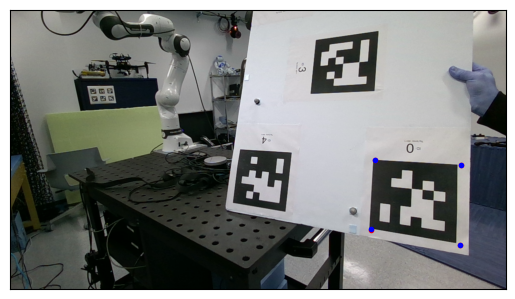

In [57]:
errors = []
for n in range(len(corners)):
    pixel_pos = corners[n].T
    cam_p = cam_T_vicon@vicon_T_marker[n]@marker_T_tag@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')
# disable ticks
plt.xticks([])
plt.yticks([])
plt.savefig('results/reprojection_before_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()

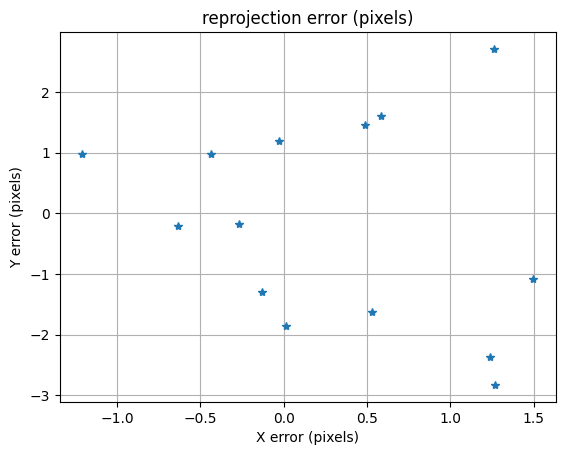

In [52]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)

## Visualization After Optimization

In [53]:
result = solver.getOptimizedResults()
X = result['X']
Y = result['Y']

In [54]:
import numpy as np
import matplotlib.pyplot as plt

imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
vicon_T_marker = data['A_list']
camera_T_tag = data['B_list']
marker_T_tag = result['X']
vicon_T_cam = result['Y']
K = data['camera_matrix']
cam_T_vicon = np.linalg.inv(vicon_T_cam)

tag_size = 0.172
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

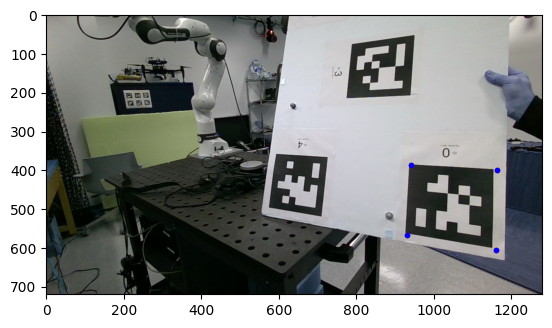

In [55]:
errors = []
for n in range(len(corners)):
    pixel_pos = corners[n].T
    cam_p = cam_T_vicon@vicon_T_marker[n]@marker_T_tag@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')


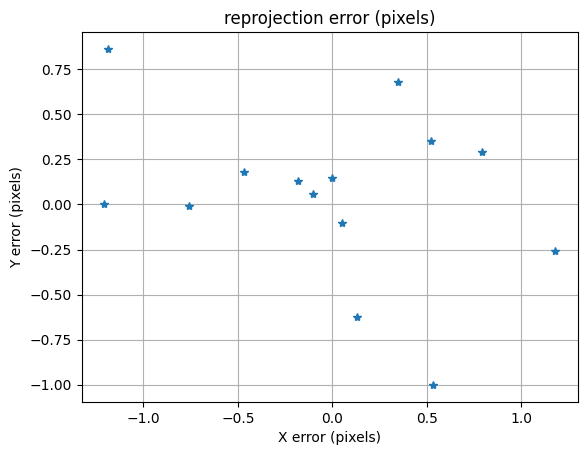

In [56]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)